In [57]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.graph_objs as go

import geopandas
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import seaborn as sb
import plotly
import dash
import plotly.offline as ply
from plotly.graph_objs import *
from scipy.io import netcdf
import scipy.stats as stat

origins = ["DR_Congo", "Afghanistan", "Syria", "Myanmar", "Sudan"]
destinations = ["USA", "UK", "France", "Canada", "Italy", "Germany"]

org_codes = ["COD", "AFG", "SYR", "MMR", "SDN"]
dest_codes = ["USA", "GBR", "FRA", "CAN", "ITA","DEU"]

years = [2000 + i for i in range(19)]

features = ['destination',
 'Origin',
 'applied',
 'accepted',
 'Rejected',
 'decisions',
 'Year',
 'Month',
 'Value',
 'deaths',
 'last_month',
 'two_months_ago',
 'next_month',
 'two_months_later']


months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]

combos = []
for year in years:
    for month in months:
        combos.append((month, year))


coordinates = {}
coordinates["Syria"] = (34.8, 38.997)
coordinates["DR_Congo"] = (-4.0383, 21.759)
coordinates["Afghanistan"] = (33.939, 67.71)
coordinates["Sudan"] = (12.863, 30.218)
coordinates["Myanmar"] = (21.9162, 95.956)

coordinates["USA"] = (37.09, -95.713)
coordinates["UK"] = (55.378, -3.436)
coordinates["France"] = (46.228, 2.214)
coordinates["Germany"] = (51.166, 10.4515)
coordinates["Italy"] = (41.872, 12.5674)
coordinates["Canada"] = (56.1304, -106.3468)


dest_longs = [coordinates[dest][1] for dest in destinations]
dest_lats = [coordinates[dest][0] for dest in destinations]

org_longs = [coordinates[org][1] for org in origins]
org_lats = [coordinates[org][0] for org in origins]

pairs = []
for origin in origins:
    for destination in destinations:
        pairs.append((origin, destination))

# Read in data
df = pd.read_csv('./data/all_merged.csv', skipinitialspace=True)

symbols = {'DR_Congo': 'triangle-down', 'Sudan': 'square', 'Syria': 'cross',\
            'Myanmar':'star', 'Afghanistan': 'circle'}

In [58]:
for month in months:
    df.ix[df.Month.str.contains(month), ['Month']] = month
month_ids = []
markers = []
origin_ids = []
d_lats = []
d_longs = []
o_lats = []
o_longs = []
for index, row in df.iterrows():
    markers.append(symbols[row["Origin"]])
    month = row.Month
    month_ids.append(months.index(month) + 1)
    origin_ids.append(origins.index(row.Origin))
    d_lats.append(coordinates[row.destination][0])
    o_lats.append(coordinates[row.Origin][0])
    d_longs.append(coordinates[row.destination][1])
    o_longs.append(coordinates[row.Origin][1])
df['shapes'] = markers
df['month_id'] = month_ids
df['month_number'] =12*(df['Year']-2000) + df['month_id']
df['origin_id'] = origin_ids
df['dest_lat'] = d_lats
df['dest_long'] = d_longs
df['org_lat'] = o_lats
df['org_long'] = o_longs

/Users/jasonterry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



In [59]:
list(df)

['Unnamed: 0',
 'destination',
 'Origin',
 'applied',
 'accepted',
 'Rejected',
 'decisions',
 'Year',
 'Month',
 'Value',
 'deaths',
 'shapes',
 'month_id',
 'month_number',
 'origin_id',
 'dest_lat',
 'dest_long',
 'org_lat',
 'org_long']

In [51]:
grouped = df.groupby('destination')

In [52]:
group_dict = {}
for (name, df) in grouped:
    group_dict[name] = df

In [53]:
group_dict[list(group_dict.keys())[0]].sample(5)

,Unnamed: 0,destination,Origin,applied,accepted,Rejected,decisions,Year,Month,Value,deaths,shapes,month_id,month_number,origin_id
1958,1958,USA,Myanmar,264.0,246.0,138.0,481.0,2005,Jun,19.0,142.0,star,6,66,3
2075,2075,USA,Afghanistan,45.0,42.0,39.0,130.0,2005,Jul,1.0,1736.0,circle,7,67,1
5147,5147,USA,Sudan,182.0,92.0,33.0,187.0,2013,Feb,5.0,1519.0,square,2,158,4
136,136,USA,Afghanistan,443.0,333.0,82.0,523.0,2000,May,20.0,5235.0,circle,5,5,1
711,711,USA,Afghanistan,499.0,341.0,70.0,521.0,2001,Dec,14.0,5308.0,circle,12,24,1


## Plot with dropdown menu that chooses origin. Shows all refugees for each country

In [36]:
fig = go.FigureWidget(
    data=[dict(
        x = df.query('Origin == @origin')['month_number'],
        y = df.query('Origin == @origin')['Value'],
        name = origin, 
        mode = 'markers',
        opacity = 0.6
    ) for origin in origins
    ]
)
years = [2000 + i for i in range(18)]
marker_places= [12*i for i in range(18)]
tick_labs = [str(year) for year in years]
fig.layout.hovermode = 'closest'
fig.layout.yaxis.title = 'Refugees Taken In'
# fig.layout.xaxis.title = 'Month'
fig.layout.xaxis.ticktext = tick_labs
fig.layout.xaxis.tickvals = marker_places

In [37]:
from ipywidgets import interact

@interact(menu = destinations)
def update_arguments(menu=['Canada']):
    for i in range(len(fig.data)):
        origin = fig.data[i]['name']
        fig.data[i].x = group_dict[menu].query('Origin == @origin')\
                        .month_number
        fig.data[i].y = group_dict[menu].query('Origin == @origin')\
                        .Value + \
                        np.random.rand(len(group_dict[menu]\
                                           .query('Origin == @origin')\
                        .month_number))
    fig.layout.title = 'Refugees taken in by ' + menu
fig

interactive(children=(Dropdown(description='menu', options=('USA', 'UK', 'France', 'Canada', 'Italy', 'Germany…

FigureWidget({
    'data': [{'mode': 'markers',
              'name': 'DR_Congo',
              'opacity': 0.6…

## Routes

In [68]:
dest_dict = [ dict(
        type = 'scattergeo',
        locationmode = 'world',
        lon = dest_longs,
        lat = dest_lats,
        hoverinfo = 'text',
        text = destinations,
        mode = 'markers',
        marker = dict( 
            size=2, 
            color='rgb(255, 0, 0)',
            line = dict(
                width=3,
                color='rgba(68, 68, 68, 0)'
            )
        ))]

In [69]:
org_dict = [ dict(
        type = 'scattergeo',
        locationmode = 'world',
        lon = org_longs,
        lat = org_lats,
        hoverinfo = 'text',
        text = origins,
        mode = 'markers',
        marker = dict( 
            size=2, 
            color='rgb(255, 0, 0)',
            line = dict(
                width=3,
                color='rgba(68, 68, 68, 0)'
            )
        ))]

In [99]:
sent={}
for org in origins:
    sent[org] = []
for org in sent:
    for dest in destinations:
        sent[org].append(df.query('Origin == @org and destination == @dest').Value.sum())

In [100]:
sent

{'Afghanistan': [3235.0, 56620.0, 20210.0, 6586.0, 19412.0, 233174.0],
 'DR_Congo': [3339.0, 13682.0, 67176.0, 8435.0, 885.0, 6407.0],
 'Myanmar': [6586.0, 2279.0, 1326.0, 258.0, 53.0, 1528.0],
 'Sudan': [4542.0, 17667.0, 23780.0, 2880.0, 3146.0, 8714.0],
 'Syria': [7490.0, 13370.0, 21672.0, 5476.0, 5835.0, 539729.0]}

In [106]:
possible_locationmodes = ['ISO-3', 'USA-states', 'country names']
paths = []
colors = ['red', 'blue', 'green', 'orange', 'purple']
# for i in range(len(df.Value)):
#     paths.append(
#         dict(
#             type = 'scattergeo',
#             locationmode = 'country names',
#             lon = [df['org_long'][i], df['dest_long'][i] ],
#             lat = [ df['org_lat'][i], df['dest_lat'][i] ],
#             mode = 'lines',
#             line = dict(
#                 width = 1,
#                 color = colors[df['origin_id'][i]],
#             ),
#             opacity = 0.1,
#         )
#     )
for i in range(len(origins)):
    for ii in range(len(destinations)):
        paths.append(
            dict(
                type = 'scattergeo',
                locationmode = 'country names',
                lon = [org_longs[i], dest_longs[ii] ],
                lat = [org_lats[i], dest_lats[ii]],
                mode = 'lines',
                line = dict(
                    width = 1,
                    color = colors[i],
                ),
                opacity = sent[origins[i]][ii]/max(sent[origins[i]]),
            )
        )

In [116]:
layout = dict(
        title = 'Refugee Routes (2000 - 2018)',
        showlegend = False, 
        geo = dict(
            scope='world',
#             projection=dict( type='mercator' ),
#             projection = dict(type = 'azimuthal equal area'),
#             projection = dict(type = 'equirectangular'),
            projection = dict( 
                            type = 'orthographic',
                            rotation = dict(
                                lon = -100,
                                lat = 40,
                                roll = 0
                            )),  
            showland = True,
            showcountries = True,
#             showlakes = True,
#             showocean=True,
#             lakecolor = 'rgb(0, 255, 255)',
#             oceancolor = 'rgb(0, 255, 255)',
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )

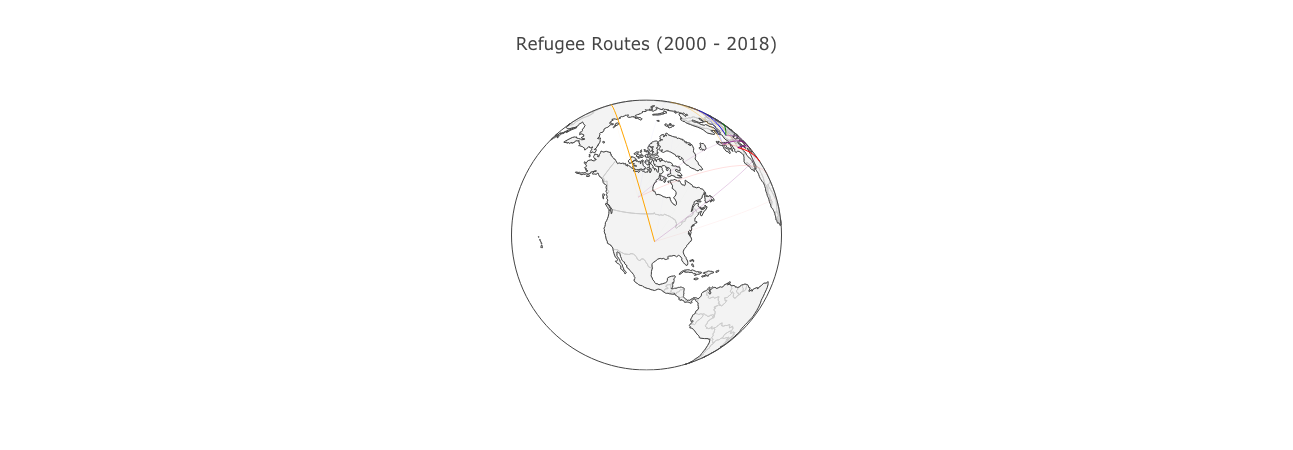

In [117]:
fig = dict(data=paths, layout=layout )
ply.iplot( fig, filename='refugee routes' )
# fig